In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from numpy import array, eye, float32
from PIL import Image

from promis import ConstitutionalController, DoubtDensity, ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianPolygon,
    CartesianRasterBand,
    PolarLocation,
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
Path("data").mkdir(exist_ok=True)

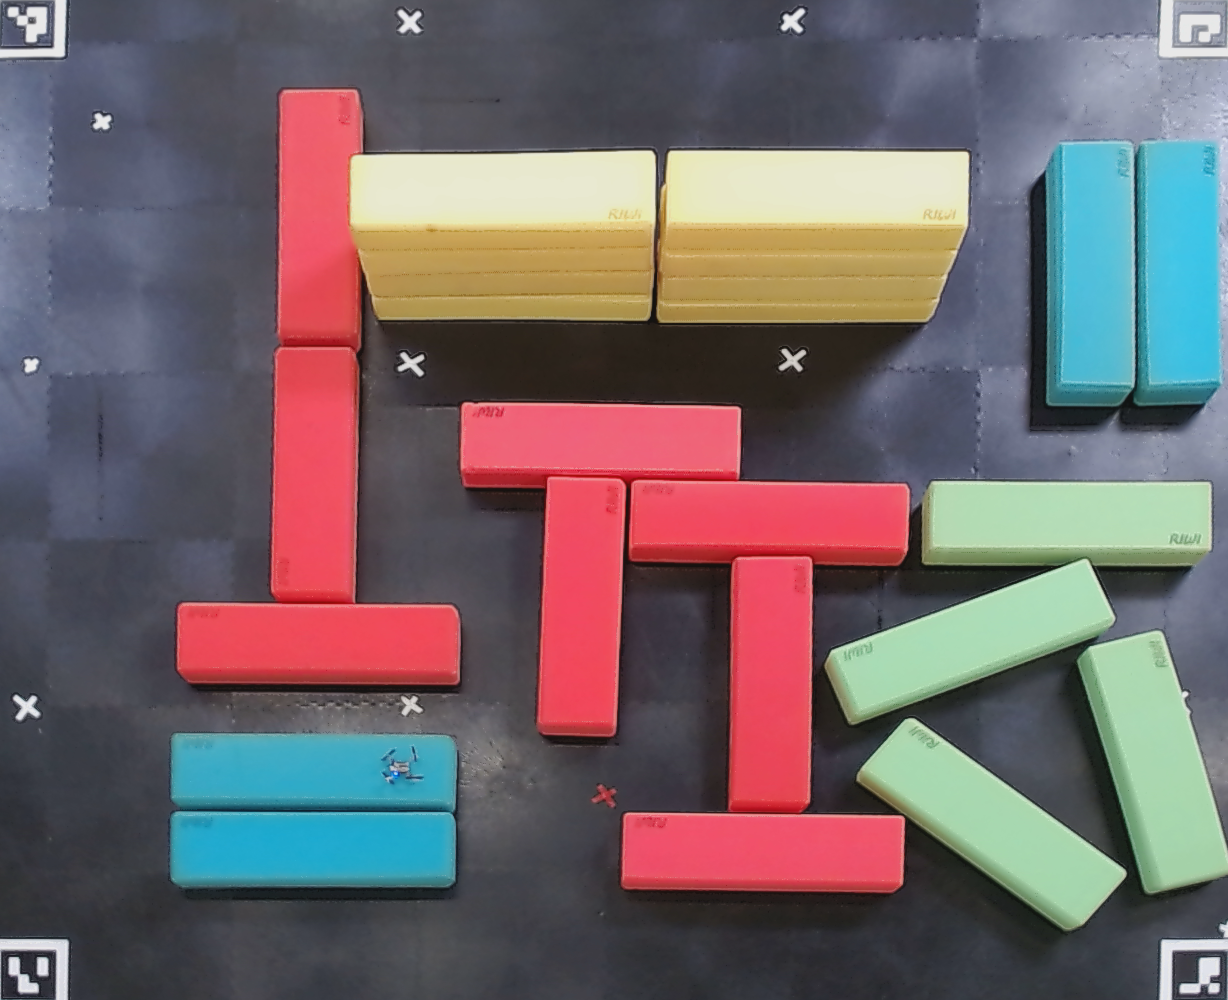

In [4]:
scene_image = Image.open("coco_linearized_image.png")
scene_image

In [5]:
boxes_df = pd.read_csv("coco_bounding_boxes.csv")
boxes_df

,x,y,width,height,area,stability_score,avg_hue,color,poly_oriented
0,857.0,718.0,268.0,213.0,23442,0.987449,60.639493,green,"[(1129, 871), (1072, 938), (850, 778), (909, 7..."
1,270.0,347.0,88.0,256.0,21633,0.983448,169.852494,red,"[(361, 347), (354, 603), (269, 603), (274, 347)]"
2,921.0,481.0,291.0,86.0,24434,0.991605,55.644512,green,"[(1212, 482), (1212, 567), (920, 565), (922, 4..."
3,824.0,560.0,290.0,165.0,22460,0.986512,63.096527,green,"[(1120, 628), (846, 728), (818, 653), (1087, 5..."
4,176.0,603.0,283.0,83.0,22956,0.984746,156.305280,red,"[(459, 604), (459, 686), (176, 684), (176, 602)]"
5,1078.0,631.0,149.0,263.0,23535,0.984483,62.889356,green,"[(1236, 874), (1144, 895), (1072, 649), (1165,..."
6,275.0,89.0,87.0,511.0,20281,0.984647,157.864947,red,"[(359, 350), (276, 344), (278, 90), (362, 88)]"
7,277.0,89.0,85.0,261.0,20277,0.985652,157.793017,red,"[(359, 350), (276, 344), (278, 90), (362, 88)]"
8,459.0,403.0,281.0,85.0,21677,0.986254,168.381510,red,"[(740, 405), (740, 478), (458, 491), (460, 401)]"
9,537.0,477.0,89.0,260.0,20830,0.985040,168.560922,red,"[(626, 478), (615, 738), (535, 734), (545, 476)]"


In [6]:
# Calculate the size of the image in millimeters
average_box_width_pixels = (277 + 281 + 245) / 3
average_box_height_pixels = (65 + 65 + 74) / 3

# True measurements in mm
box_width_mm = 800
box_height_mm = 200

# Calculate the pixel size in mm
pixel_height_mm = box_height_mm / average_box_height_pixels
pixel_width_mm = box_width_mm / average_box_width_pixels

# The image is linearized, so these two should not be too different (at most 5%)
assert abs(pixel_height_mm - pixel_width_mm) / pixel_height_mm < 0.05

# Size of the entire setup
field_width_mm = scene_image.width * pixel_width_mm
field_height_mm = scene_image.height * pixel_height_mm

(field_width_mm, field_height_mm), (pixel_height_mm, pixel_width_mm)

((3670.236612702366, 2941.1764705882356),
 (2.9411764705882355, 2.9887920298879203))

In [7]:
# Check that the aspect ratios are not too far off
(scene_image.width / scene_image.height), (field_width_mm / field_height_mm)

(1.228, 1.2478804483188044)

In [8]:
# The coordinates of the real world in millimeters

map_features = []
for index, box in boxes_df.iterrows():
    coords = array(
        json.loads(box["poly_oriented"].replace("(", "[").replace(")", "]")), dtype=float32
    )
    if coords.shape[0] != 4:
        print(f"The coordinates at index #{index} are not in the right format, skipping")
        continue

    # Rescale the coordinates from pixels to millimeters in the real world
    coords[:, 0] *= pixel_width_mm
    coords[:, 1] *= pixel_height_mm

    # Make sure that (0, 0) is the center of the cage
    coords[:, 0] -= field_width_mm / 2
    coords[:, 1] -= field_height_mm / 2
    coords[:, 1] *= -1  # Flip the y-axis to go from image to real world coordinates

    # Convert the coordinates to a CartesianPolygon
    map_features.append(CartesianPolygon.from_numpy(coords.T, location_type=box["color"]))

len(map_features), map_features[0]

(25,
 CartesianPolygon(locations=[(1539.2279052734375, -1091.1763916015625), (1368.8665771484375, -1288.2352294921875), (705.3548583984375, -817.6470947265625), (881.6934814453125, -626.4705810546875), (1539.2279052734375, -1091.1763916015625)], location_type=green, identifier=1915722327757636692))

In [9]:
# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
covariance = {
    "red": 100 * eye(2),
    "green": 100 * eye(2),
    "blue": 100 * eye(2),
    "yellow": 100 * eye(2),
}

# The probabilistic, logical constraints to fulfill during a mission
logic = r"""
%1.0::flight.

% Definition of a valid mission
% blue_rules(X) :- \+ over(X, blue), flight; \+ over(X, blue), \+ flight.

red_rules(X) :- distance(X, red) > 5.
yellow_rules(X) :- distance(X, yellow) > 5.
green_rules(X) :- \+ over(X, green).

landscape(X) :- red_rules(X), yellow_rules(X), green_rules(X).
"""

# The mission area, points that will be estimated from 25 samples and points that will be interpolated
origin = PolarLocation(latitude=0.0, longitude=0.0)  # Irrelevant for Cartesian maps
number_of_random_maps = 25
support = CartesianRasterBand(
    origin, (75, 75), field_width_mm, field_height_mm
)  # This is the set of points that will be directly computed through sampling (expensive)
target = CartesianRasterBand(
    origin, (200, 200), field_width_mm, field_height_mm
)  # This is the set of points that will be interpolated from the support set (cheap)

uam = CartesianMap(origin, map_features)
uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier

landscape_path = Path("data/virtual_setup_landscape.pkl")
if landscape_path.exists():
    landscape = CartesianCollection.load(landscape_path)

else:
    # Setting up the probabilistic spatial relations from the map data
    star_map = StaRMap(target, uam, method="linear")
    # This estimates all spatial relations that are relevant to the given logic
    star_map.initialize(support, number_of_random_maps, logic)
    star_map.save("data/virtual_setup_star_map.pkl")

    # Solve the mission area with ProMis
    promis = ProMis(star_map)
    landscape = promis.solve(support, logic, n_jobs=4, batch_size=8)
    landscape.save(landscape_path)

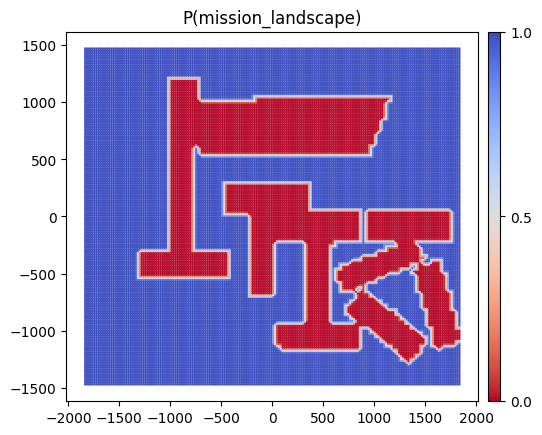

In [10]:
image = landscape.scatter(s=0.4, plot_basemap=False, rasterized=True, cmap="coolwarm_r")
cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
plt.title("P(mission_landscape)")
plt.show()

Doubt feature velocity v = 1
Search and scatter path ...


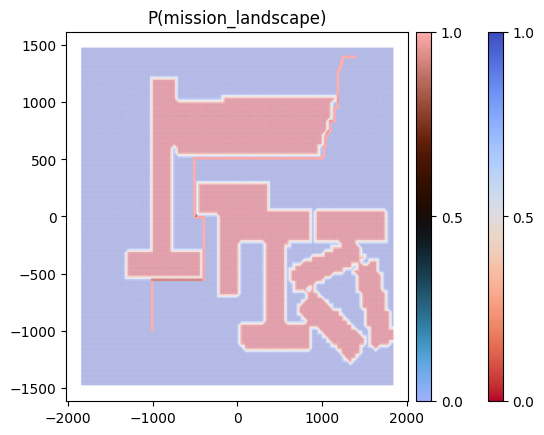

Doubt feature velocity v = 10
Search and scatter path ...


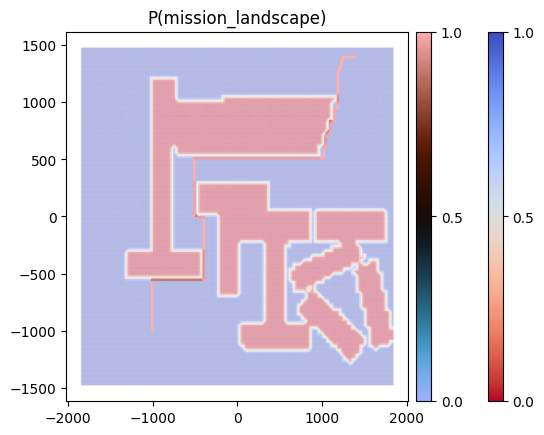

In [11]:
# Load the landscape produced by promis.ipynb and init CoCo
coco = ConstitutionalController()

# Select different doubt feature values, here we have just one feature velocity
# and use it directly as doubt density parameter
for velocity in [1, 10]:
    print(f"Doubt feature velocity v = {velocity}")

    density = DoubtDensity(velocity)
    augmented_landscape: CartesianRasterBand = coco.apply_doubt(
        landscape=landscape,
        doubt_density=density,
        number_of_samples=100,
    )

    image = augmented_landscape.scatter(
        s=0.4, plot_basemap=False, rasterized=True, cmap="coolwarm_r", alpha=0.25
    )
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
    cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
    cbar.solids.set(alpha=1)

    print("Search and scatter path ...")
    start = (-1_000, -1_000)
    goal = (1_400, 1_400)
    min_cost = 0.3
    path = augmented_landscape.search_path(
        start,
        goal,
        cost_model=lambda p: max(min_cost, 1.0 - p**3),
        value_filter=lambda p: p >= min_cost,
        min_cost=min_cost,
    )

    scatter = plt.scatter(
        [n[0] for n in path],
        [n[1] for n in path],
        s=1,
        c=[
            coco.compliance(
                path=path,
                landscape=augmented_landscape,
                doubt_density=density,
                number_of_samples=100,
            )
        ],
        vmin=0,
        vmax=1,
        cmap="berlin",
    )
    cbar = plt.colorbar(scatter, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
    cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
    cbar.solids.set(alpha=1)

    # ticks = [-500, 0, 500]
    # labels = ["0", "0.5", "1"]

    # plt.xlabel("Easting / km")
    # plt.ylabel("Northing / km")
    # plt.xticks(ticks, labels)
    # plt.yticks(ticks, labels)
    # plt.xlim([-500, 500])
    # plt.ylim([-500, 500])

    plt.title("P(mission_landscape)")
    plt.show()